<a href="https://colab.research.google.com/github/Thiraput01/My_ML_learning/blob/main/CNN/FashionMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Download and Analyze the dataset

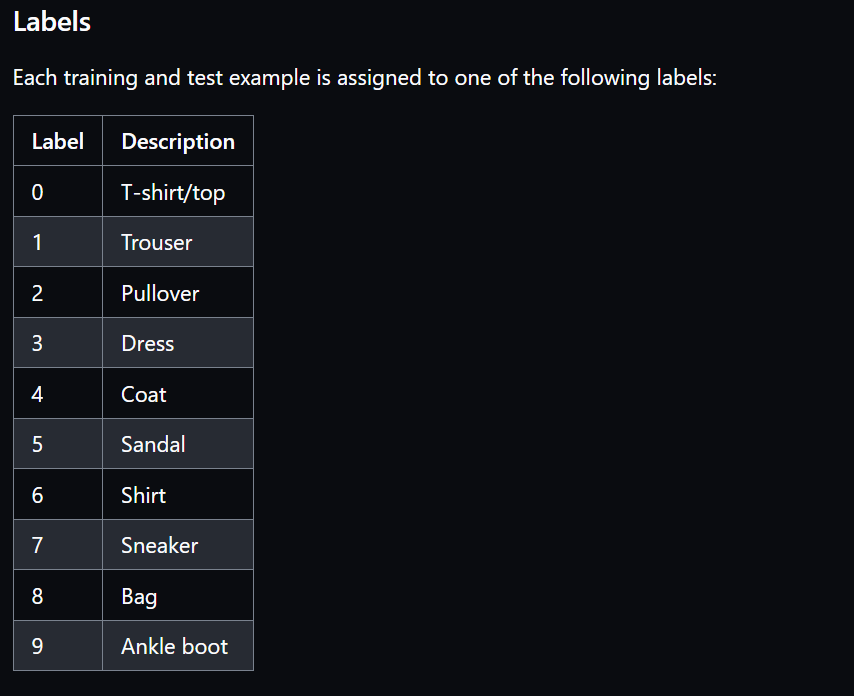



> Source of fashionMnist [Here](https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file)



In [4]:
transform = transforms.ToTensor()

batch_size = 8

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# lookup table
classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

100%|██████████| 26421880/26421880 [00:02<00:00, 12765149.32it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204617.27it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3763382.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5845229.29it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
train_iter = iter(trainset)

img, label = next(train_iter)

img.shape, label

(torch.Size([1, 28, 28]), 9)

In [6]:
torch.min(img).item(), torch.max(img).item()

(0.0, 1.0)

Ankle Boot


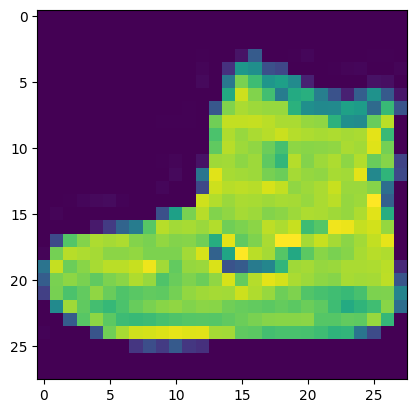

In [7]:
np_img = img.numpy()
print(classes[label])
plt.imshow(np_img.reshape(28, 28, 1))


# Split training set for validation set



In [8]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [9]:
print(f"Number of batches in the training set: {int(50000/batch_size)}")
print(f"Number of batches in the validation set: {int(10000/batch_size)}")
print(f"Number of batches in the test set: {int(10000/batch_size)}")

Number of batches in the training set: 6250
Number of batches in the validation set: 1250
Number of batches in the test set: 1250


> Change datatype to dataloader



In [10]:
# current type
type(trainset)

torch.utils.data.dataset.Subset

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
data_iter = iter(trainloader)
img, label = next(data_iter)
img.shape, label

(torch.Size([8, 1, 28, 28]), tensor([3, 4, 3, 2, 1, 0, 4, 6]))



> Above shape shows that img has
8 batches for [1, 28, 28] image


> And label for each image in batches





In [13]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

# Create a Model

In [14]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    # frist layer: conv2D using 3x3 kernel(window)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, stride=1)
    # using maxpool
    self.pool1 = nn.MaxPool2d(2, 2)

    # second layer: conv2D using 3x3 kernel(window)
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1)
    self.pool2 = nn.MaxPool2d(2, 2)

    # third layer: conv2D using 3x3 kernel(window)
    self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2, stride=1)
    self.pool3 = nn.MaxPool2d(2, 2)


    # flatten into vector
    self.flatten = nn.Flatten()

    # plug into fully connected layer
    # using dropout to reduce overfitting
    self.fc1 = nn.Linear(in_features=4096, out_features=1024)
    self.drop1 = nn.Dropout(p=0.3)

    self.fc2 = nn.Linear(in_features=1024, out_features=1024)
    self.drop2 = nn.Dropout(p=0.3)

    # output layer
    self.out = nn.Linear(in_features=1024, out_features=10)



  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)

    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = self.flatten(x)

    x = F.relu(self.fc1(x))
    x = self.drop1(x)

    x = F.relu(self.fc2(x))
    x = self.drop2(x)

    x = self.out(x)
    return x


In [15]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [16]:
for i, data in enumerate(trainloader):
  inputs, labels = data[0], data[1]
  inputs, labels = inputs.to(device), labels.to(device)
  print(f'input shape: {inputs.shape}')
  print(f'after network shape: {net(inputs).shape}')
  break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


In [17]:
# count parameters
c = 0
for x in net.parameters():
  c += len(torch.flatten(x))
print(f'Number of parameters in the model: {c:,}')

Number of parameters in the model: 8,536,074


# Prepare to train the model

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [24]:
def train_one_epoch():
  net.train(True)
  running_loss = 0.0
  running_accuracy = 0.0

  for batchIdx, data in enumerate(trainloader):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to(device), labels.to(device)

    # reset grad
    optimizer.zero_grad()

    # run inputs throughout the network
    outputs = net(inputs) # shape: [batch_size, 10]
    corrects = torch.sum(labels == torch.argmax(outputs, dim=1)).item() # returns int in [0,8], represents howmany labels model got it right
    running_accuracy += corrects / batch_size

    # calculate loss
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # backprop
    loss.backward()
    optimizer.step()

    if batchIdx % 500 == 499: # print every 500 batches
      avg_loss_across_batches = running_loss / 500
      avg_accuracy_across_batches = (running_accuracy / 500) * 100
      print(f'Batch {batchIdx+1:02}, Loss: {avg_loss_across_batches:.3f}, Accuracy: {avg_accuracy_across_batches:.1f}% ')

      running_loss = 0.0
      running_accuracy = 0.0

print()


In [25]:
def validate_one_epoch():
  net.train(False)
  running_loss = 0.0
  running_accuracy = 0.0

  for i, data in enumerate(valloader):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():

      outputs = net(inputs)
      corrects = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
      running_accuracy += corrects / batch_size

      loss = criterion(outputs, labels)
      running_loss += loss.item()


  avg_loss_across_batches = running_loss / len(valloader)
  avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
  print(f'Val Loss: {avg_loss_across_batches:.3f}, Val Accuracy: {avg_accuracy_across_batches:.1f}% ')

  print('************************************')
  print()

# Train the model

In [26]:
num_epochs= 10

for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}\n')

  train_one_epoch()
  validate_one_epoch()

print("finished training")

Epoch 1

Batch 500, Loss: 0.287, Accuracy: 89.4% 
Batch 1000, Loss: 0.267, Accuracy: 89.8% 
Batch 1500, Loss: 0.275, Accuracy: 89.9% 
Batch 2000, Loss: 0.272, Accuracy: 89.7% 
Batch 2500, Loss: 0.277, Accuracy: 90.0% 
Batch 3000, Loss: 0.290, Accuracy: 89.8% 
Batch 3500, Loss: 0.262, Accuracy: 90.3% 
Batch 4000, Loss: 0.274, Accuracy: 89.8% 
Batch 4500, Loss: 0.270, Accuracy: 90.4% 
Batch 5000, Loss: 0.290, Accuracy: 89.3% 
Batch 5500, Loss: 0.267, Accuracy: 90.0% 
Batch 6000, Loss: 0.265, Accuracy: 89.8% 
Val Loss: 0.267, Val Accuracy: 90.2% 
************************************

Epoch 2

Batch 500, Loss: 0.248, Accuracy: 91.0% 
Batch 1000, Loss: 0.223, Accuracy: 91.7% 
Batch 1500, Loss: 0.254, Accuracy: 90.7% 
Batch 2000, Loss: 0.261, Accuracy: 90.7% 
Batch 2500, Loss: 0.247, Accuracy: 91.4% 
Batch 3000, Loss: 0.230, Accuracy: 91.2% 
Batch 3500, Loss: 0.244, Accuracy: 90.5% 
Batch 4000, Loss: 0.239, Accuracy: 91.3% 
Batch 4500, Loss: 0.222, Accuracy: 91.3% 
Batch 5000, Loss: 0.222, A

# Test the model

In [27]:
def test_model():
  net.train(False)
  running_loss = 0.0
  running_accuracy = 0.0

  for i, data in enumerate(testloader):
    inputs, labels = data[0], data[1]
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():

      outputs = net(inputs)
      corrects = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
      running_accuracy += corrects / batch_size

      loss = criterion(outputs, labels)
      running_loss += loss.item()


  avg_loss_across_batches = running_loss / len(testloader)
  avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
  print(f'Test Loss: {avg_loss_across_batches:.3f}, Test Accuracy: {avg_accuracy_across_batches:.1f}% ')


In [29]:
test_model()

Test Loss: 0.361, Test Accuracy: 91.9% 


Pretty acceptable... I guess